# 10 階層ベイズモデル -GLMMのベイズモデル化-

In [23]:
using CSV
using DataFrames
using Distributions
using ForneyLab
using LaTeXStrings
using Mamba
using Plots
using QuadGK
using StatsBase
using StatsFuns

## 10.1 例題 : 個体差と生存種子数 (個体差あり)

In [2]:
df = CSV.read("data/section10a.csv")
disallowmissing!(df)

,id,y
,Int64,Int64
1,1,0
2,2,2
3,3,7
4,4,8
5,5,1
6,6,7
7,7,8
8,8,8
9,9,1


青丸は観測データ, 白丸は生存確率0.504の二項分布. 二項分布では観測データのばらつきが説明できていない

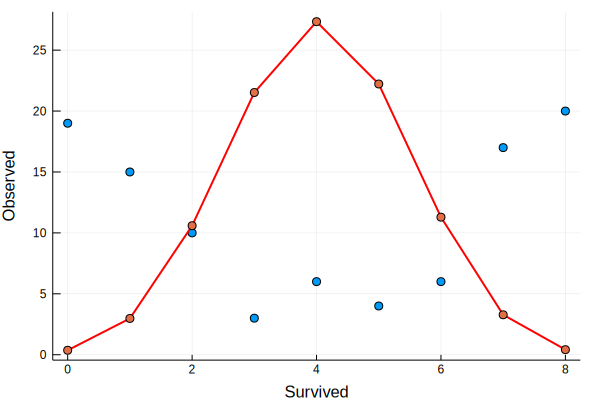

In [3]:
scatter(sort(unique(df.y)), counts(df.y), label = "")
ys = pdf.(Binomial(8, 0.504), 0:8) .* 100
plot!(0:8, ys, linecolor = :red, linewidth = 2,
    marker = 4, label = "",
    xlabel = "Survived", ylabel = "Observed")

## 10.3 階層ベイズモデルの推定・予測
### 10.3.1 階層ベイズモデルのMCMCサンプリング
### モデルの作成

In [4]:
model = Model(
    y = Stochastic(1,
        (beta, r, N) ->
            UnivariateDistribution[
                (q = invlogit(beta + r[i]);
                Binomial(8, q)) for i in 1:N
            ],
        false
    ),
    
    beta = Stochastic(() -> Normal(0, 100)),
    
    r = Stochastic(1,
        (s, N) -> 
            UnivariateDistribution[
                Normal(0, s) for i in 1:N
            ],
        false
    ),
    
    s = Stochastic(() -> Uniform(0, 10000)),
)

Object of type "Model"
-------------------------------------------------------------------------------
beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
r:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


### モデルの図示

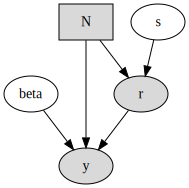

In [5]:
display("image/svg+xml", ForneyLab.dot2svg(graph2dot(model)))

### データの設定

In [6]:
data = Dict{Symbol, Any}(
    :y => df.y,
    :N => length(df.y),
)

Dict{Symbol,Any} with 2 entries:
  :N => 100
  :y => [0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0]

### 初期値の設定

In [7]:
inits = [
    Dict{Symbol, Any}(
        :y => df.y,
        :beta => 0.0,
        :r => rand(Normal(0, 0.1), length(df.y)),
        :s => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta=>0.0,:y=>[0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0],:s=>1.0,:r=>[-0.154809, 0.0751543, 0.0770578, 0.227205, 0.11715, -0.117894, -0.0657295, -0.0854577, -0.169458, -0.1024  …  0.0447787, 0.0202447, 0.124211, -0.10625, 0.0384102, 0.0786048, -0.0689631, -0.0373613, -0.0218091, 0.053974])        
 Dict(:beta=>0.0,:y=>[0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0],:s=>1.0,:r=>[0.0527813, -0.152127, 0.0421713, -0.0357567, -0.0485423, -0.0120864, 0.23683, 0.148011, -0.181611, 0.0784441  …  0.0853085, -0.00333471, -0.0209705, 0.0560662, 0.0743064, 0.0740819, -0.0827452, -0.0544974, 0.0733662, -0.146061])
 Dict(:beta=>0.0,:y=>[0, 2, 7, 8, 1, 7, 8, 8, 1, 1  …  6, 2, 8, 6, 6, 1, 0, 4, 7, 0],:s=>1.0,:r=>[-0.0940604, 0.105853, -0.0957962, -0.00493166, -0.0154123, 0.0783574, -0.0833015, 0.0376455, -0.117982, 0.00437959  …  0.0751062, -0.0293448, 0.0928192, 0.0240459, 0.124476, 0.0611634, -0.14931, 0.14661, -0.0298

### MCMCサンプル方法の設定
NUTSを使うと遅くなってしまったので、AMWGを使用

In [8]:
scheme = [
    Slice(:s, 1.0, Mamba.Univariate),
    Slice(:beta, 1.0, Mamba.Univariate),
    AMWG(:r, 1),
]

3-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.SliceTune{Distributions.Univariate}}"
Sampling Block Nodes:
Symbol[:s]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                                                           
 An object of type "Sampler{Mamba.SliceTune{Distributions.Univariate}}"
Sampling Block Nodes:
Symbol[:beta]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                                   

### MCMCサンプリング
サンプリングは20000回実施し, burn-inの数は1000, 10飛ばしの結果の記録を3チェイン行うので、サンプルの数は(20000-1000)/10*3=5700個

In [9]:
setsamplers!(model, scheme)
sim = mcmc(model, data, inits, 20000, burnin = 1000, thin = 10, chains = 3)

MCMC Simulation of 20000 Iterations x 3 Chains...

Chain 1:   0% [0:38:37 of 0:38:38 remaining]
Chain 1:  10% [0:01:47 of 0:01:58 remaining]
Chain 1:  20% [0:01:30 of 0:01:52 remaining]
Chain 1:  30% [0:01:17 of 0:01:50 remaining]
Chain 1:  40% [0:01:05 of 0:01:48 remaining]
Chain 1:  50% [0:00:54 of 0:01:48 remaining]
Chain 1:  60% [0:00:43 of 0:01:47 remaining]
Chain 1:  70% [0:00:32 of 0:01:47 remaining]
Chain 1:  80% [0:00:21 of 0:01:47 remaining]
Chain 1:  90% [0:00:11 of 0:01:46 remaining]
Chain 1: 100% [0:00:00 of 0:01:46 remaining]

Chain 2:   0% [0:01:47 of 0:01:47 remaining]
Chain 2:  10% [0:01:34 of 0:01:45 remaining]
Chain 2:  20% [0:01:24 of 0:01:45 remaining]
Chain 2:  30% [0:01:13 of 0:01:45 remaining]
Chain 2:  40% [0:01:03 of 0:01:45 remaining]
Chain 2:  50% [0:00:52 of 0:01:45 remaining]
Chain 2:  60% [0:00:42 of 0:01:45 remaining]
Chain 2:  70% [0:00:31 of 0:01:45 remaining]
Chain 2:  80% [0:00:21 of 0:01:45 remaining]
Chain 2:  90% [0:00:10 of 0:01:45 remaining]
Cha

Object of type "ModelChains"

Iterations = 1010:20000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 1900

[3.18291 -0.11434; 2.94252 -0.228871; … ; 2.82901 0.169802; 2.61506 -0.11275]

[2.71998 -0.0247134; 2.65458 -0.141735; … ; 3.40308 -0.0267639; 3.34482 -0.239366]

[3.0806 0.355269; 3.04602 -0.0369003; … ; 2.65905 0.0596091; 3.35357 0.060581]

### サンプリング結果を表示

In [10]:
describe(sim)

Iterations = 1010:20000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 1900

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE        ESS   
   s 3.032142470 0.36989465 0.0048993743 0.0077971068 1900.0000
beta 0.036703956 0.33792536 0.0044759308 0.0099877637 1144.7353

Quantiles:
        2.5%       25.0%       50.0%       75.0%     97.5%  
   s  2.3853609  2.77076635 3.006884402 3.26460993 3.8389351
beta -0.6277372 -0.18832505 0.041297043 0.26492714 0.6779581



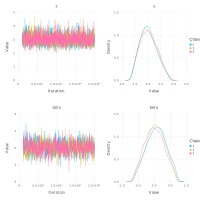

In [11]:
p = Mamba.plot(sim, legend = true)
Mamba.draw(p, nrow = 2, ncol = 2)

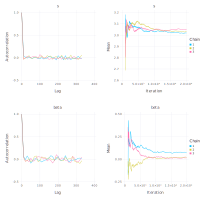

In [12]:
p = Mamba.plot(sim, [:autocor, :mean], legend=true)
Mamba.draw(p, nrow = 2, ncol = 2)

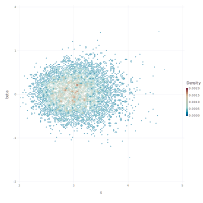

In [13]:
p = Mamba.plot(sim, :contour)
Mamba.draw(p, nrow = 1, ncol = 1)

### 10.3.2 階層ベイズモデルの事後分布推定と予測
$p(y \mid \beta, r)p(r \mid s)$を求める関数

In [14]:
function f_gaussian_binorm(alpha, x, size, fixed, sd)
   pdf(Binomial(size, logistic(fixed + alpha)), x) * pdf(Normal(0, sd), alpha)
end

f_gaussian_binorm (generic function with 1 method)

$p(y \mid \beta, s) = \int_{-\infty}^\infty p(y \mid \beta, r)p(r \mid s)dr$を求める関数. 
実際は$\int_{-10s}^{10s} p(y \mid \beta, r)p(r \mid s)dr$を求めている

In [15]:
function d_gaussian_binorm(x, fixed, sd)
    quadgk(y -> f_gaussian_binorm(y, x, 8, fixed, sd), -sd * 10, sd * 10)[1]
end

d_gaussian_binorm (generic function with 1 method)

各パスに対し, $y = 0, \ldots, 8$ に対して $p(y \mid \beta, s)$ を評価する.

In [16]:
posterior = map((x, y) -> d_gaussian_binorm.(0:8, x, y), sim[:, [:beta], :].value[:], sim[:, [:s], :].value[:])

5700-element Array{Array{Float64,1},1}:
 [0.23689, 0.106671, 0.0756425, 0.0642641, 0.0609528, 0.0634771, 0.0736612, 0.101804, 0.216637]  
 [0.232734, 0.11349, 0.0816447, 0.0694211, 0.0654929, 0.0674671, 0.0767878, 0.101973, 0.19099]   
 [0.229502, 0.109133, 0.0784034, 0.0668915, 0.0634723, 0.065935, 0.0760116, 0.103369, 0.207283]  
 [0.157553, 0.0916395, 0.0719564, 0.0651108, 0.0648155, 0.0704197, 0.0851487, 0.122892, 0.270464]
 [0.21204, 0.0910743, 0.0651652, 0.0563331, 0.0546259, 0.0585437, 0.0708193, 0.105607, 0.285792] 
 [0.157887, 0.0829916, 0.0637588, 0.0574763, 0.0574917, 0.0632493, 0.0783714, 0.119434, 0.319339]
 [0.160861, 0.089342, 0.0692939, 0.0624436, 0.0621391, 0.0676974, 0.082444, 0.12112, 0.284659]   
 [0.174435, 0.09435, 0.0720807, 0.0642034, 0.0632117, 0.0680989, 0.0818148, 0.117765, 0.264041]  
 [0.176389, 0.0876178, 0.0657481, 0.0583651, 0.0576554, 0.0626897, 0.076708, 0.115047, 0.29978]  
 [0.14003, 0.0927338, 0.0760642, 0.0702398, 0.0706, 0.0768508, 0.0922079, 0.12

各パスに対して、$P(X=y)=p(y \mid \beta, s)\ \text{for}\ y = 0, \ldots, 8$というCategorical distributionから100個体のサンプリングを行い, $y$ごとに出現回数を数える. 横方向は各サンプリング, 縦方向は$y = 0, \ldots, 8$の出現回数に該当

In [17]:
population_samples = hcat(map(x -> fit(Histogram, rand(Distributions.Categorical(x), 100) .- 1, 0:9).weights, posterior)...)

9×5700 Array{Int64,2}:
 23  24  26  17  19  14  11  18  10  …  30  22  25  23  18  21  26  17  20
 12  14   7   7   9   6   4   8   8      9  15  11   7   4  10   8  13   5
  7   8  12  10   7   7   7   7   7     10   7   3   9  10   9   4  14  10
  2   7   5   3   4   5   8   6  13     13   7  11  12   9   4   4   7   8
  6   4   6   5   4   5  10  10   5      6   5   7   6  10  11   7   8   3
  9   8   6   8   8   8   7   8   5  …   3   6   3   7   6   7   4   6   8
  9   7   8   8   5  10  13   2   6     10   8  11  10   7   6   9  11   7
  5  14  11  17  19   9  10  11  12      8   5   9   9   7   3   7  10  11
 27  14  19  25  25  36  30  30  34     11  25  20  17  29  29  31  14  28

$y$毎に出現回数の2.5%, 50%, 97.5%点を計算

In [18]:
function quantile_sample(r)
    map(x -> quantile(population_samples[x, :], r), 1:9)
end
quantile_sample_0025 = quantile_sample(0.025)
quantile_sample_0975 = quantile_sample(0.975)
quantile_sample_median = quantile_sample(0.5)

9-element Array{Float64,1}:
 21.0
 10.0
  8.0
  7.0
  6.0
  7.0
  8.0
 11.0
 22.0

### 生存種子数の予測分布
各 $y$ における中央値, 及び95%区間の領域を表示する

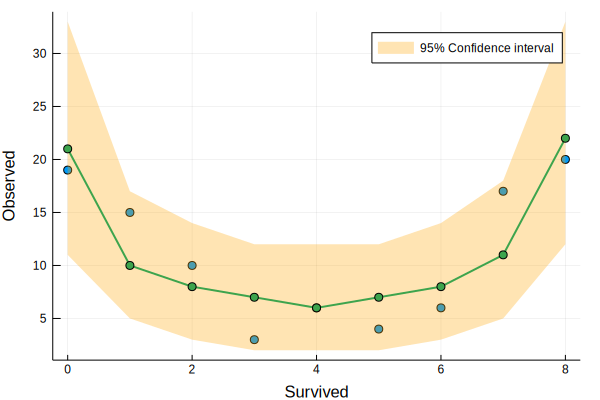

In [19]:
scatter(sort(unique(df.y)), counts(df.y), label = "")
Plots.plot!(0:8, quantile_sample_0025, lw = 0, 
    fillrange = quantile_sample_0975,
    fillalpha = 0.3, fillcolor = :orange,
    label = "95% Confidence interval")
Plots.plot!(0:8, quantile_sample_median, linewidth = 2, marker = 4, label = "",
            xlabel = "Survived", ylabel = "Observed")

## 10.5 個体差 + 場所差の階層ベイズモデル

In [20]:
df2 = CSV.read("data/section10b.csv")
disallowmissing!(df2)

,id,pot,f,y
,Int64,String,String,Int64
1,1,A,C,6
2,2,A,C,3
3,3,A,C,19
4,4,A,C,5
5,5,A,C,0
6,6,A,C,19
7,7,A,C,4
8,8,A,C,8
9,9,A,C,12


In [21]:
marker_dict = Dict(
    "A" => :circle,
    "B" => :ltriangle,
    "C" => :star5,
    "D" => :diamond,
    "E" => :dtriangle,
    "F" => :xcross,
    "G" => :star4,
    "H" => :utriangle,
    "I" => :rect,
    "J" => :rtriangle
)

Dict{String,Symbol} with 10 entries:
  "B" => :ltriangle
  "A" => :circle
  "I" => :rect
  "J" => :rtriangle
  "C" => :star5
  "D" => :diamond
  "G" => :star4
  "E" => :dtriangle
  "F" => :xcross
  "H" => :utriangle

### 個体ごとの表示
赤線は無処理、青線は堆肥処理した個体の平均

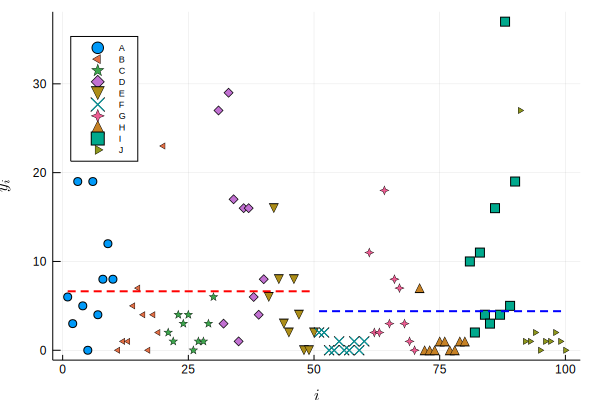

In [24]:
plt = Plots.plot()
for k in sort(collect(keys(marker_dict)))
    df_k = df2[df2[:pot] .== k, :]
    scatter!(df_k.id, df_k.y, label = k, markershape = marker_dict[k],
        legend = :topleft, legendfontsize = 6, xlabel = L"i", ylabel = L"y_i")
end
plot!(1:50, fill(mean(df2[1:50, :].y), 50), linestyle = :dash, linewidth = 2, linecolor = :red, label = "")
plot!(51:100, fill(mean(df2[51:100, :].y), 50), linestyle = :dash, linewidth = 2, linecolor = :blue, label = "")
plt